### Часть 1 (Кобелев Роман)

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
x= np.loadtxt("data_x.txt",dtype=int)
y= np.loadtxt("data_y.txt",dtype=int)
data = np.loadtxt("data.txt",dtype=int)
n = sum(sum(data))
print(f"n = {n}")

n = 200


In [129]:
df = pd.DataFrame(data, columns=[y[0], y[1], y[2], y[3]])
df.set_index(x, inplace=True)

df

,15,25,30,35
10,15,0,0,0
20,10,80,30,0
30,0,0,45,20


In [130]:
df_new = df.div(n)
df_new['P(x=xi*)'] = df_new.sum(axis=1)
df_new.loc['qj*'] = df_new.sum(axis=0)
df_new

,15,25,30,35,P(x=xi*)
10,0.075,0.0,0.000,0.0,0.075
20,0.050,0.4,0.150,0.0,0.600
30,0.000,0.0,0.225,0.1,0.325
qj*,0.125,0.4,0.375,0.1,1.000


$\widetilde{M}(x) = \sum_{i=1}^n (x_i^*)p_i^*$

$\widetilde{D}(x) = \sum_{i=1}^n (x_i^*)^2p_i^* - (\widetilde{M}(x))^2$

$\widetilde{M}(y) = \sum_{j=1}^m (y_j^*)q_j^*$

$\widetilde{D}(y) = \sum_{j=1}^m (y_j^*)^2q_j^* - (\widetilde{M}(y))^2$

In [131]:
m_x = sum(index * row['P(x=xi*)'] if index != "qj*" else 0 for index, row in df_new.iterrows())
d_x = sum(index**2 * row['P(x=xi*)'] if index != "qj*" else 0 for index, row in df_new.iterrows()) - m_x**2
sigma_x = np.sqrt(d_x)
m_y = sum(column * df_new[column].iloc[-1] if column != "P(x=xi*)" else 0 for column in df_new.columns)
d_y = sum(column**2 * df_new[column].iloc[-1] if column != "P(x=xi*)" else 0 for column in df_new.columns) - m_y**2
sigma_y = np.sqrt(d_y)
   
print(f"m_x = {m_x}, d_x = {d_x}, sigma_x = {sigma_x:.3} m_y = {m_y}, d_y = {d_y}, sigma_y = {sigma_y:.3}")

m_x = 22.5, d_x = 33.75, sigma_x = 5.81 m_y = 26.625, d_y = 29.234375, sigma_y = 5.41


$\overline{k(x,y)} = \overline{cov(x, y)} = \sum_{i=1}^n\sum_{j=1}^m x_i^*y_j^*p_i^* - \widetilde{M}(x)\widetilde{M}(y)$

In [132]:
k = sum((index) * (column) * row[column] if index != "qj*" and column != "P(x=xi*)" else 0 for column in df_new.columns for index, row in df_new.iterrows()) - m_x * m_y
k

24.6875

$\widetilde{r_{xy}} = \cfrac{\widetilde{k(x,y)}}{\widetilde{\sigma}(x)\widetilde{\sigma}(y)}$

In [133]:
r = k / (sigma_x * sigma_y)
print(f"r = {r:.3}")

r = 0.786


### Часть 2 (Балин Артем)

Чтобы построить зависимость условного математического ожидания константы $y$ от значений компонент $x$, нужно найти значения математических ожиданий из условных рядов распределения

In [134]:
relative_data_y = []
for i in range(len(x)):
    row_in_relative = []
    for j in range(len(y)):
        x_current = x[i]
        y_current = y[j]
        row_in_relative.append(df_new[y_current][x_current]/df_new['P(x=xi*)'][x_current])
    relative_data_y.append(row_in_relative)
relative_y_index = [f"P(y=y_i|x={x_i})" for x_i in x]
relative_y = pd.DataFrame(relative_data_y,columns=[y_i for y_i in y])
relative_y.index = relative_y_index
relative_y

,15,25,30,35
P(y=y_i|x=10),1.000000,0.000000,0.000000,0.000000
P(y=y_i|x=20),0.083333,0.666667,0.250000,0.000000
P(y=y_i|x=30),0.000000,0.000000,0.692308,0.307692


Теперь построим таблицу условных математических ожиданий $y$ при различных значениях $x$:

In [135]:
relative_means_y = []
for row in relative_data_y:
    relative_means_y.append([sum(row[i]*y[i] for i in range(len(y)))])
means_y = pd.DataFrame(relative_means_y, columns=["M(y|x=x_i)"]).T
means_y.columns = x
means_y

,10,20,30
M(y|x=x_i),15.0,25.416667,31.538462


Построим линию регрессии $y$ на $x$:

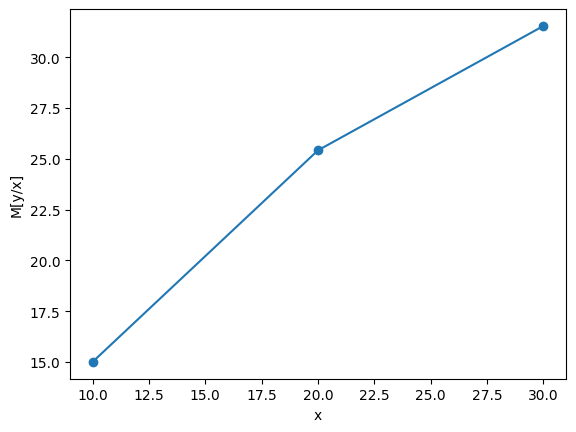

In [136]:
plt.plot(x, relative_means_y, marker='o', linestyle='-')
plt.xlabel('x')
plt.ylabel('M[y/x]')
plt.show()

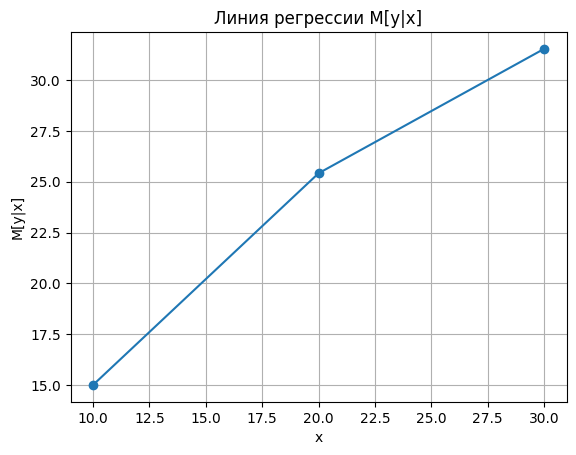

In [19]:
# %% [markdown]
# Теперь построим таблицу условных математических ожиданий $y$ при различных значениях $x$:

# %%
# Математическое ожидание M(y|x)
relative_means_y = []
for row in relative_data_y:
    relative_means_y.append([sum(row[i] * y[i] for i in range(len(y)))])
means_y = pd.DataFrame(relative_means_y, columns=["M(y|x=x_i)"]).T
means_y.columns = x
means_y

# %% [markdown]
# Построим линию регрессии $y$ на $x$:

# %%
# Линия регрессии
plt.plot(x, relative_means_y, marker='o', linestyle='-')
plt.xlabel('x')
plt.ylabel('M[y|x]')
plt.title('Линия регрессии M[y|x]')
plt.grid(True)
plt.show()

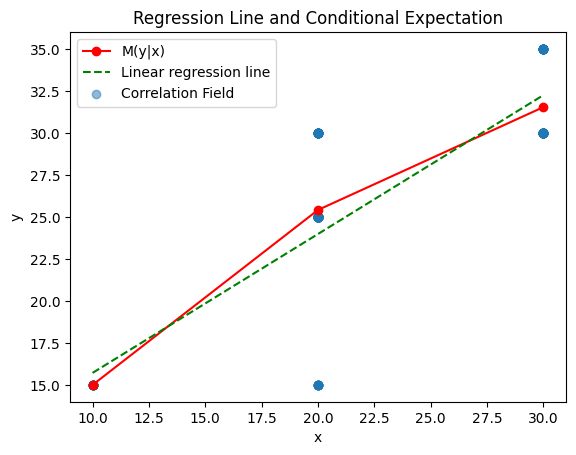

Linear regression coefficients: [0.82692308 7.4465812 ]


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Условный ряд распределения для X при y = y2
y2 = y[1]
conditional_x_given_y2 = df_new[y2] / df_new.loc['qj*'][y2]
conditional_x_given_y2_df = pd.DataFrame(conditional_x_given_y2, columns=[f'P(x|y={y2})'])


# Подготовка данных для корреляционного поля
correlation_data = []
for i in range(len(x)):
    for j in range(len(y)):
        # Добавляем точки (x, y) по количеству случаев в таблице данных
        correlation_data.extend([(x[i], y[j])] * data[i, j])

correlation_data = np.array(correlation_data)

# Построение корреляционного поля
# plt.scatter(correlation_data[:, 0], correlation_data[:, 1], alpha=0.5)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Correlation Field')
# plt.show()

# Построение линейной регрессии
coeffs = np.polyfit(x, np.array(relative_means_y).flatten(), deg=1)
line_y = np.polyval(coeffs, x)

plt.plot(x, relative_means_y, marker='o', color='red', linestyle='-', label='M(y|x)')
plt.plot(x, line_y, color='green', linestyle='--', label='Linear regression line')
plt.scatter(correlation_data[:, 0], correlation_data[:, 1], alpha=0.5, label='Correlation Field')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regression Line and Conditional Expectation')
plt.legend()
plt.show()

# Коэффициенты линейной регрессии
print(f'Linear regression coefficients: {coeffs}')